# GMM after PCA

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../pca"))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from GMM import GMM
from PCA import PCA
from covariance_types import CovarianceType
import seaborn as sns

from external_metrics import *
from internal_metrics import *


load data

In [2]:
X = pd.read_csv("../data_processed.csv").to_numpy()
Y = pd.read_csv("../data.csv")["diagnosis"].to_numpy()

In [3]:
X,Y

(array([[ 1.09609953, -2.0715123 ,  1.26881726, ...,  2.2940576 ,
          2.74820411,  1.93531174],
        [ 1.82821197, -0.35332152,  1.68447255, ...,  1.08612862,
         -0.24367526,  0.28094279],
        [ 1.5784992 ,  0.45578591,  1.56512598, ...,  1.95328166,
          1.15124203,  0.20121416],
        ...,
        [ 0.70166686,  2.04377549,  0.67208442, ...,  0.41370467,
         -1.10357792, -0.31812924],
        [ 1.83672491,  2.33440316,  1.98078127, ...,  2.28797231,
          1.9173959 ,  2.21768395],
        [-1.80681144,  1.22071793, -1.81279344, ..., -1.7435287 ,
         -0.04809589, -0.75054629]], shape=(569, 30)),
 array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
        'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', '

Initialize best GMM parameters from the GMM experiment

In [4]:
covariance_types = [CovarianceType.FULL, CovarianceType.TIED,
                    CovarianceType.DIAG, CovarianceType.SPHERICAL]
k = 2
cov_type = CovarianceType.FULL
gmm = GMM(k=k,covariance_type=cov_type,conv_limit=1e-6,max_iter=100,seed=42)


Initialize PCA

In [5]:
pca = PCA(X)
n_vals = range(1,20)


Initialize covariance types and number of clusters

## 1. Internal Validation Metrics

Append all evaluation metrics initially in a loop

In [6]:
results = []
for n in n_vals:
    # fit pca
    x_transformed = pca.fit_transform(n)
    # fit gmm
    gmm.fit(x_transformed)
            # Cluster assignments
    r = gmm.r
    clusters = np.argmax(r, axis=1)
    
    # Compute metrics
    bic_score = gmm.bic(x_transformed)
    aic_score = gmm.aic(x_transformed)
    sil_score = silhouette_score(x_transformed, clusters)
    db_score = davies_bouldin(x_transformed, clusters)
    ch_score = calinski_harabasz(x_transformed, clusters)
    
    # External metrics
    ari = adjusted_rand_index(Y, clusters)
    nmi = normalized_mutual_info(Y, clusters)
    purity = purity_score(Y, clusters)
    
    # Binary classification metrics
    binary_metrics = compute_binary_metrics(Y, clusters, positive_class='M')
    
    # Store results
    results.append({
        "Number of components": n,
        "BIC": bic_score,
        "AIC": aic_score,
        "Silhouette": sil_score,
        "Davies-Bouldin": db_score,
        "Calinski-Harabasz": ch_score,
        "ARI": ari,
        "NMI": nmi,
        "Purity": purity,
        "Accuracy": binary_metrics['accuracy']
    })

df_metrics = pd.DataFrame(results)

In [7]:
print(purity)

0.8172231985940246


Get the best model

In [8]:
best_bic_row = df_metrics.loc[df_metrics['BIC'].idxmin()]
best_n = int(best_bic_row['Number of components'])
# Fit best model
x_transformed = pca.fit_transform(best_n)
gmm.fit(x_transformed)
# Cluster assignments
r = gmm.r
clusters = np.argmax(r, axis=1)

# Map clusters to true classes for interpretability
mapped_clusters = map_clusters_to_labels(clusters, assign_clusters_to_classes(Y, clusters))


Plot the best model

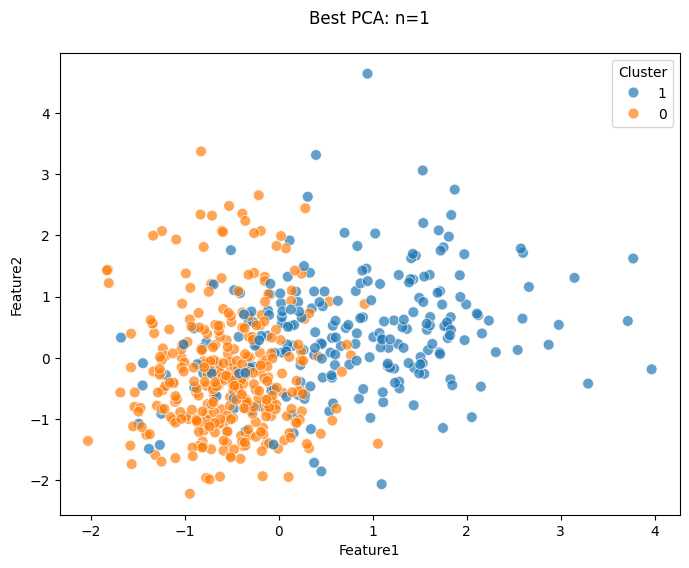

In [9]:
df_clusters = pd.DataFrame({
    'Feature1': X[:,0],
    'Feature2': X[:,1],
    'Cluster': clusters.astype(str)
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_clusters,
    x='Feature1',
    y='Feature2',
    hue='Cluster',
    palette='tab10',
    s=60,
    alpha=0.7
)
plt.title(f"Best PCA: n={best_n}\n")
plt.show()


Plot each metric

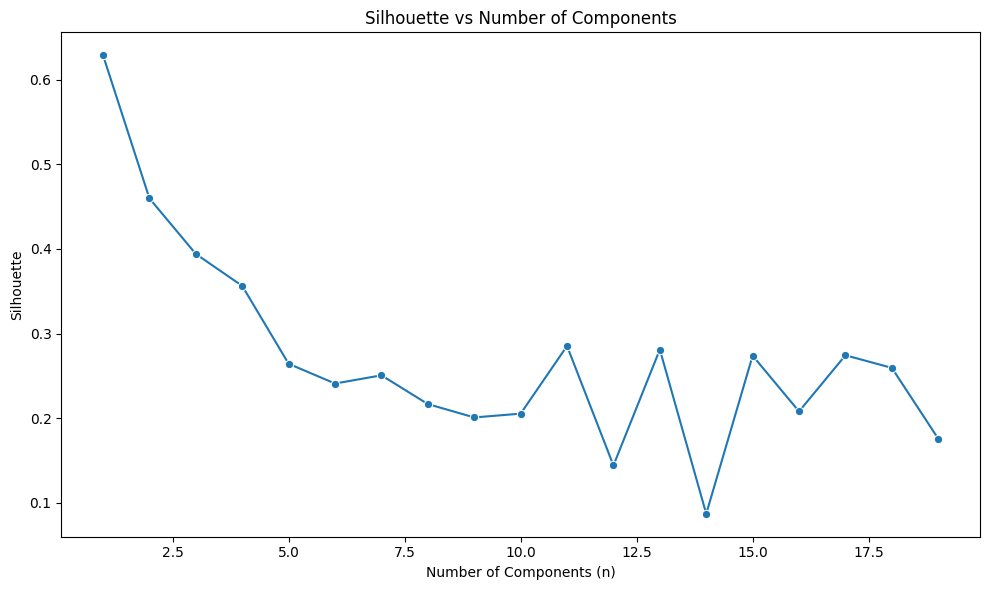

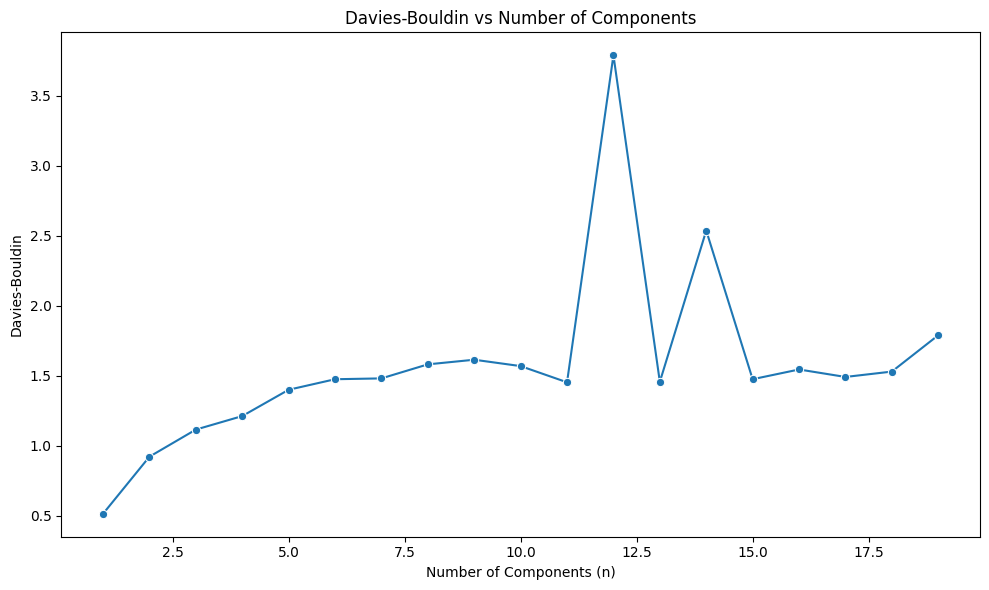

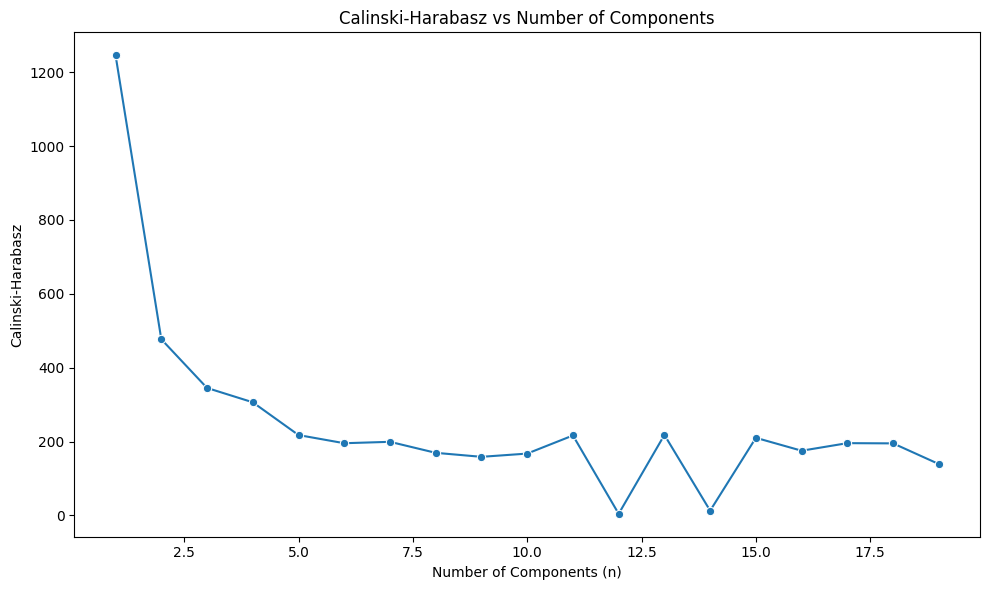

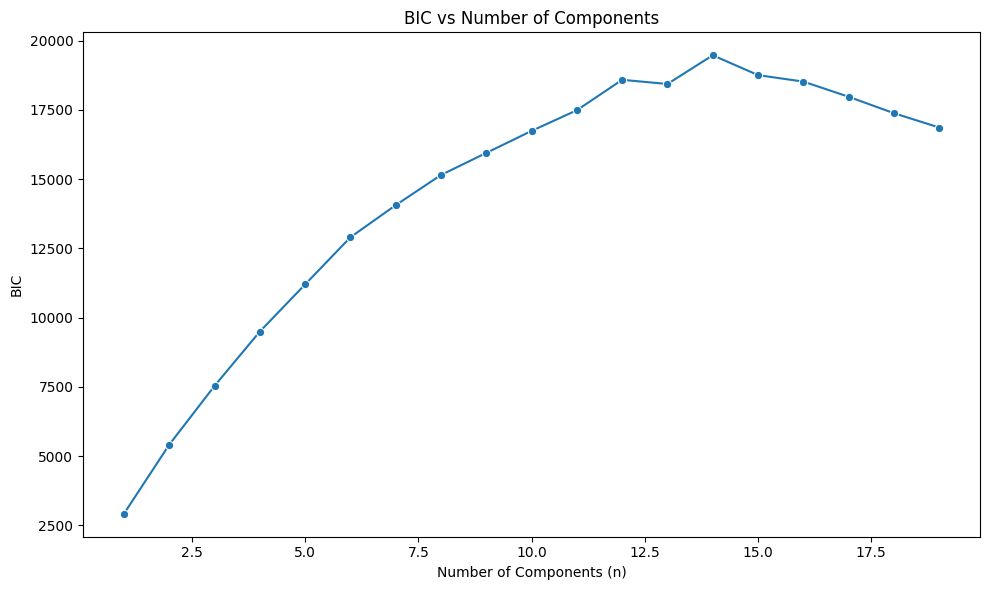

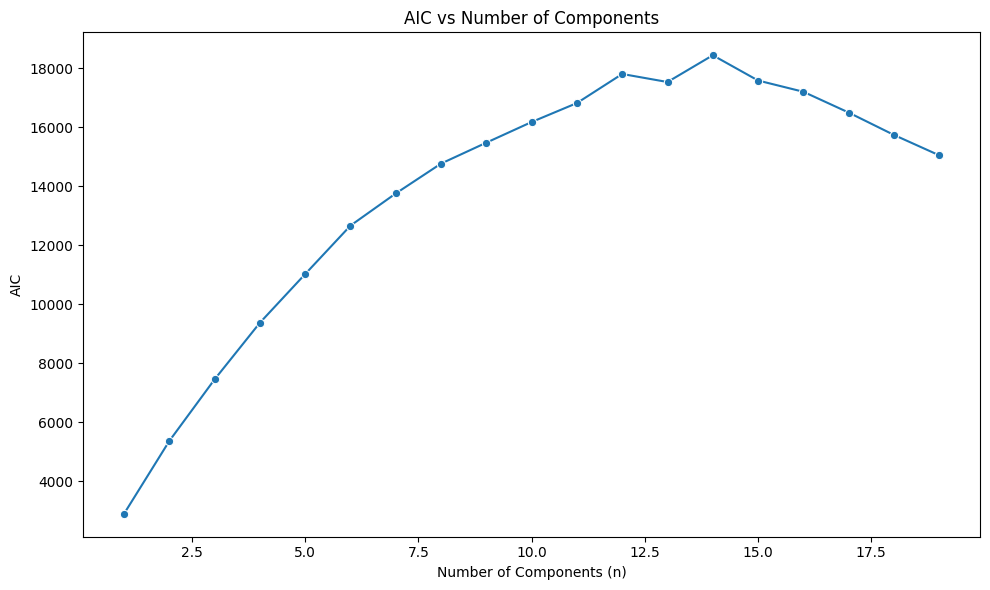

In [16]:

metrics_to_plot = [
    "Silhouette", "Davies-Bouldin", "Calinski-Harabasz",
    "BIC", "AIC"
]

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df_metrics,
        x="Number of components",
        y=metric,
        marker="o"
    )

    plt.title(f"{metric} vs Number of Components")
    plt.xlabel("Number of Components (n)")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


## 2. External Validation Metrics

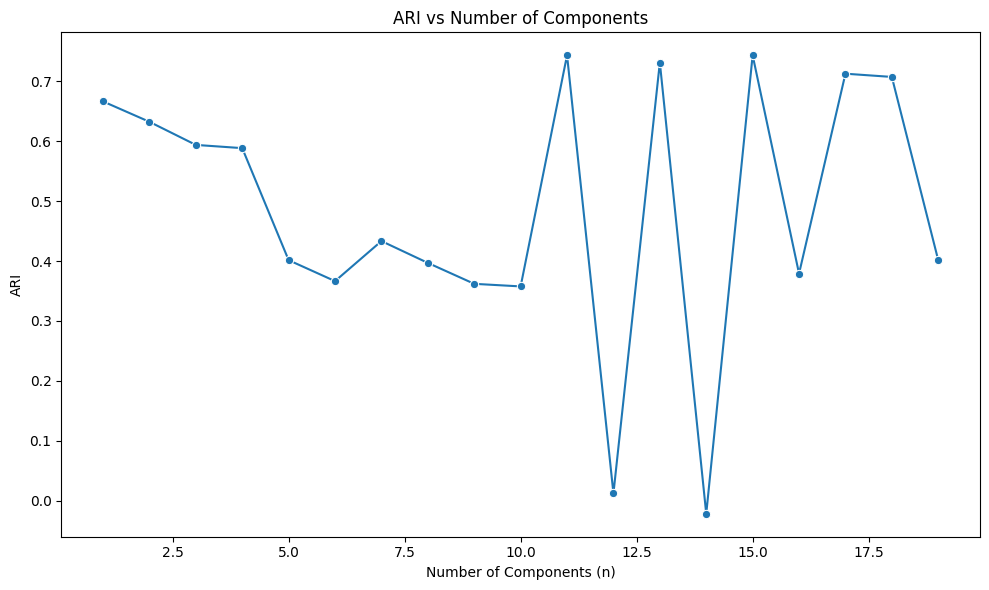

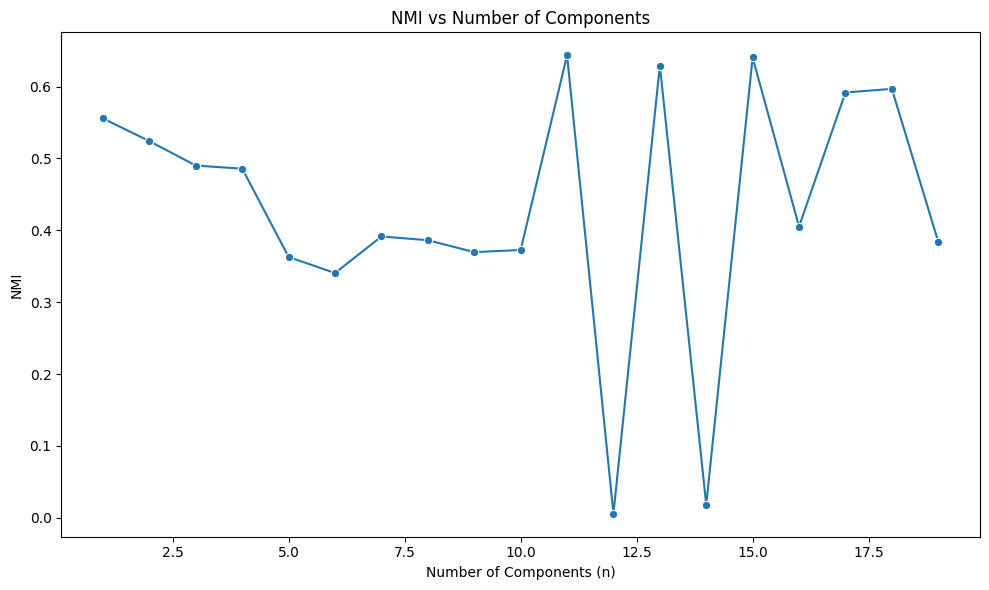

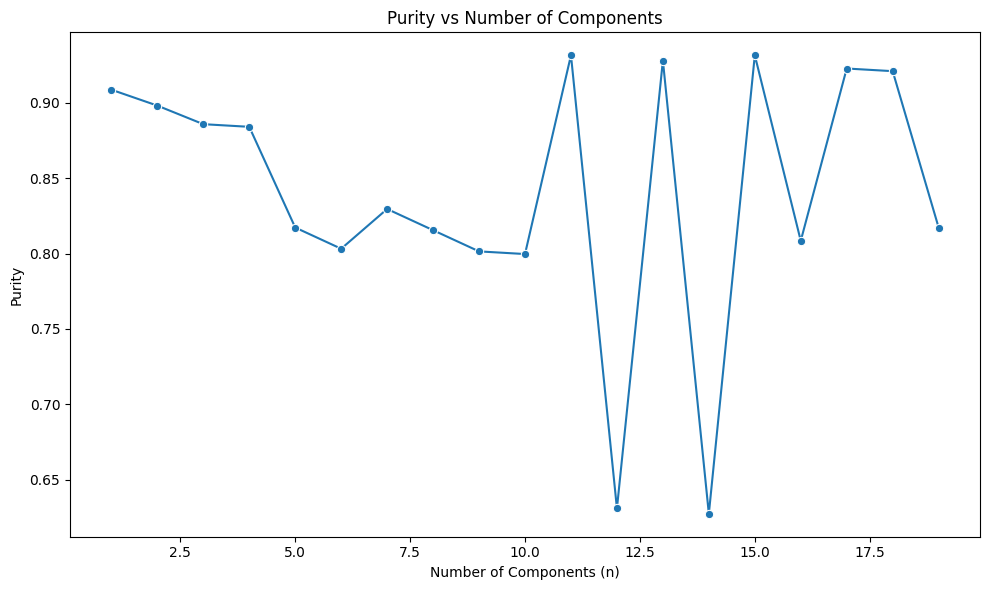

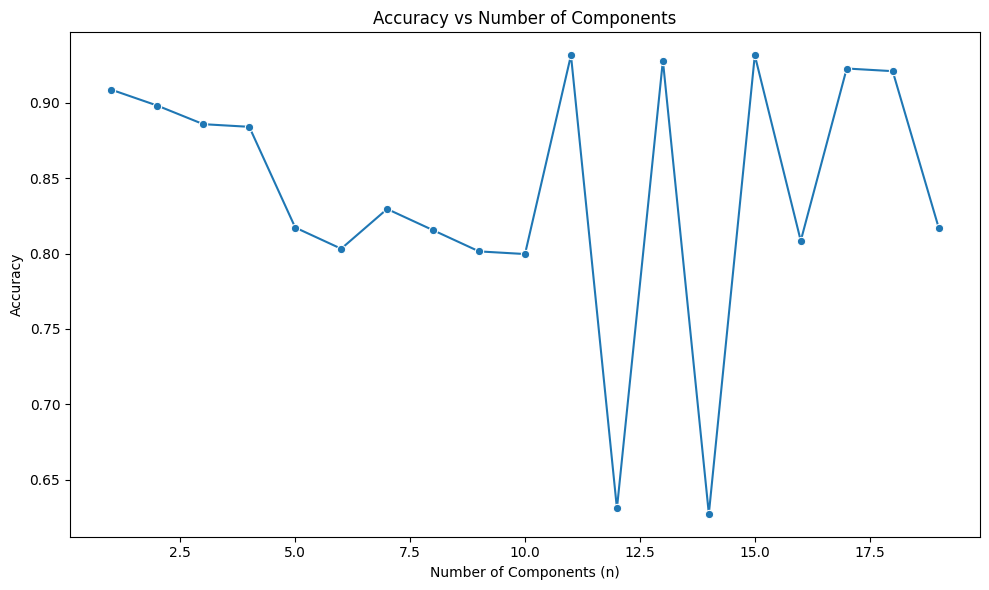

In [17]:
metrics_to_plot = [
 "ARI", "NMI", "Purity", "Accuracy"
]

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df_metrics,
        x="Number of components",
        y=metric,
        marker="o"
    )

    plt.title(f"{metric} vs Number of Components")
    plt.xlabel("Number of Components (n)")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


Confusion Matrix for the best model

In [12]:
# confusion matrix: true labels vs clusters
cm = confusion_matrix(Y, mapped_clusters)


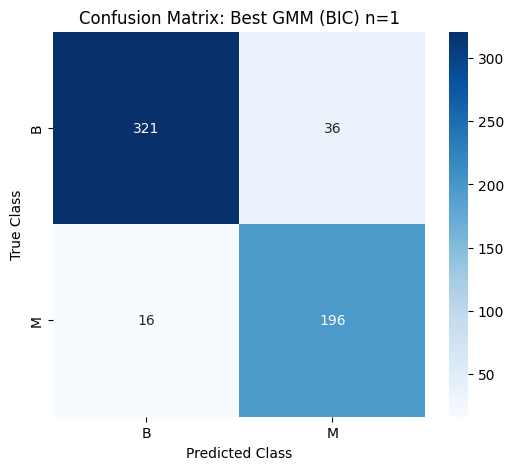

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(mapped_clusters),
            yticklabels=np.unique(Y))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix: Best GMM (BIC) n={best_n}")
plt.show()